# Planteamiento de la prueba técnica

- Partiendo de la base de datos transaccional realice la carga y el respectivo preprocesamiento de los datos, encuentre patrones o comportamientos que sean relevantes para identificar el hábito transaccional de los clientes y presente un análisis descriptivo de esta información.
-  Luego identifique los grupos para cada estrategia (descuento) considerando el tipo de uso (Compra y avances), justificar la metodología que le permitió asignar cada uno de los clientes en los diferentes grupos y dimensionar la cantidad de clientes para cada estrategia.

## Consideraciones

- El equipo de mercadeo tiene una estrategia y desea incentivar la compra en estos clientes, la estrategia tendrá descuentos dirigidos de 5%, 20%, 25% en su próxima compra y tenga en cuenta que no todos los clientes necesitan un incentivo. Nos dicen desde el equipo de mercadeo que debemos priorizar la magnitud de los descuentos en los grupos que tienen menos uso en nuestras tarjetas, tanto en compras, como en avances.
- Los clientes que son muy afines a realizar avances pero poco afines a realizar compras, necesitamos incentivarlos a realizar compras.
- Se considera que los clientes con más afinidad a nuestro producto, son clientes con mayor número de compras, mayor facturación y al menos una utilización hace pocos días.

# Solución de la prueba técnica

La solución de esta prueba se realizará en el entorno de Anaconda usando Python. Se dejarán comentarios en el código para una mejor lectura.

In [1]:
# Importando librerías a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

## Cargando los dataset

In [2]:
# Cargando la tabla Detalle_cliente a un dataframe llamado df_1
df_1 = pd.read_excel('Prueba proceso de selección Analista de Datos - bases.xlsx')
df_1.head()

,Id_cliente,fecha_efectiva,Id_tx
0,136,20210303.0,6869
1,116,20201129.0,4355
2,119,20200929.0,5416
3,121,20210222.0,3249
4,152,20200930.0,2774


In [3]:
# Cargando la tabla Detalle_cliente a un dataframe llamado df_2
df_2 = pd.read_excel('Prueba proceso de selección Analista de Datos - bases.xlsx', sheet_name='Detalle_tx')
df_2.head()

,Id_tx,clase,valor
0,6869,COMPRA,3495240
1,4355,COMPRA,475800
2,5416,COMPRA,115775
3,3249,COMPRA,1579898
4,2774,COMPRA,84077


In [4]:
# Combinando df_1 y df_2 para crear un dataframe llamado df
df = pd.merge(df_1, df_2, left_on='Id_tx', right_on='Id_tx', how='inner')
df.head()

,Id_cliente,fecha_efectiva,Id_tx,clase,valor
0,136,20210303.0,6869,COMPRA,3495240
1,116,20201129.0,4355,COMPRA,475800
2,116,20201129.0,4355,COMPRA,350503.62
3,124,20210120.0,4355,COMPRA,475800
4,124,20210120.0,4355,COMPRA,350503.62


## Transformación y limpieza del dataframe

Antes de realizar cualquier análisis debemos asegurarnos que la calidad de los datos sea adecuada ya que estos pueden hacer que realicemos mediciones erróneas y con sesgos.

In [5]:
# visualizando información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3336 entries, 0 to 3335
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id_cliente      3336 non-null   int64  
 1   fecha_efectiva  3318 non-null   float64
 2   Id_tx           3336 non-null   int64  
 3   clase           3331 non-null   object 
 4   valor           3304 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 130.4+ KB


Podemos evidenciar que el dataframe contiene 3336 filas y 5 columnas, además podemos notar que existen valores nulos en las columnas fecha_efectiva, clase y valor, estos valores los eliminaremos para terminos de esta prueba ya que usar la moda, media u otra métrica, nos alterará nuestro análisis. En el mismo orden de ideas, la columna fecha_efectiva es de tipo float64, lo cual no es adecuado para una columna de fecha, también se hará un procesamiento sobre esa columna.

In [6]:
# Eliminando filas con valores nulos
df.dropna(subset=['fecha_efectiva'], inplace=True)
df.dropna(subset=['clase'], inplace=True)
df.dropna(subset=['valor'], inplace=True)

A la hora de seguir realizando limpieza y transformación, notamos que en la columna valor existen registros tipeados como 41f30, 3_8383, 4000'00. Estos registros nos generaran problemas a la hora de querer convertir la columna valor a float, por lo tanto los eliminaremos tambien. Cabe destacar que en la columna fecha_efectiva, también existen errores de tipeo, de igual forma se omitiran estos registros.

In [7]:
# Eliminando valores atípicos
df = df[df['valor'] != '41f30']
df = df[df['valor'] != '3_8383']
df = df[df['valor'] != "4000'00"]
df = df[df['fecha_efectiva'] != "202012"]
df = df[df['fecha_efectiva'] != "202001"]
df = df[df['fecha_efectiva'] != "2021"]
df = df[df['fecha_efectiva'] != "2020"]

In [8]:
# Cambiando el tipo de dato de la columna valor a tipo float
df["valor"] = df["valor"].astype('float')

# Cambiando el tipo de dato de las columna Id_cliente y Id_tx a tipo string
df["Id_cliente"] = df["Id_cliente"].astype('str')
df["Id_tx"] = df["Id_tx"].astype('str')

# Convertir la columna fecha a string con el mismo formato
df['fecha_efectiva'] = pd.to_datetime(df['fecha_efectiva'], errors='coerce', format='%Y%m%d', exact=False).dt.strftime('%Y%m%d')

df.dropna(subset=['fecha_efectiva'], inplace=True) # validación de valores nulos

Para el caso de este ejercicio omitiremos la clase SEGURO, por lo que eliminaremos dichos registros.

In [9]:
# Eliminar las filas con la columna clase que hagan referencia a SEGURO
df = df[df['clase'] != 'SEGURO']
df.head()

,Id_cliente,fecha_efectiva,Id_tx,clase,valor
0,136,20210303,6869,COMPRA,3495240.00
1,116,20201129,4355,COMPRA,475800.00
2,116,20201129,4355,COMPRA,350503.62
3,124,20210120,4355,COMPRA,475800.00
4,124,20210120,4355,COMPRA,350503.62


Logramos mantener la estructura del dataframe sin perder registros lo cual es bueno, ahora al tener el dataframe listo para ser analizado, haremos un análisis previo de las variables categóricas y la variable númerica.

## Análisis introductorio

In [10]:
# Información de las variables categóricas
df.describe(include='O').T

,count,unique,top,freq
Id_cliente,3266,70,125,137
fecha_efectiva,3266,190,20201121,51
Id_tx,3266,2086,6276,16
clase,3266,2,COMPRA,2543


Acá podemos visualizar ciertos datos relevantes para nuestro análisis, donde podemos notar que para este dataframe existen 70 clientes, donde el cliente 125 es el que más transacciones posee, la fecha donde más transacciones se realizaron fue el 2020-11-21, el código de transacción que más registros generó fue el 6276 y la clase más frecuente fue la COMPRA. Con esto tenemos una visión general de lo que podemos encontrarnos más adelante.

In [11]:
# Estadística básica de la variable númerica
round(df.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
valor,3266.0,376515.48,575869.15,20.0,63685.75,167211.0,484050.0,7952039.23


A primera vista noto una desviación estándar y un máximo muy altos, lo que me hace suponer que existen outliers(valores atípicos). Estos valores debemos manejarlos ya que al momento de hacer nuestras distribuciones, nos creará una visión distorsionada de la distribución real del valor de las transacciones. De igual forma podemos visualizar que el promedio por transacción ronda los 375 mil.

## Análisis exploratorio de datos

Al tener una visión previa de los datos, procedemos a realizar un análisis exploratorio de datos. Donde primeramente identificaremos cuanto dinero en transacciones se generó y cuales son los clientes que más dinero  en transacciones gastaron.

In [12]:
# suma total por transacciones
round(df['valor'].sum(), 2)

1229699556.55

Al realizar la suma de total de las transacciones, nos da un valor de 1229699556.55. Ahora procedemos a buscar las variables que más dinero nos generaron.

### Top 5 clientes con más valor en transacciones

In [13]:
# Agrupando los valores de transacciones por cliente
df_cliente = df.groupby('Id_cliente')['valor'].sum().sort_values(ascending=False).reset_index()

# Creando columna que muestra el porcentaje que representa la suma del valor del cliente sobre el total
df_cliente['porcentaje_valor_total'] = ((df_cliente['valor']) / (df['valor'].sum())) * 100

# Renombrando las columnas
df_cliente = df_cliente.rename(columns={'valor': 'total_valor_cliente', 
                                        'porcentaje_valor_total': '% sobre total_valor'})
df_cliente.head() # Visualizando el Top 5 clientes

,Id_cliente,total_valor_cliente,% sobre total_valor
0,129,53537848.42,4.353734
1,125,48310692.88,3.928658
2,131,47572387.55,3.868619
3,130,47418622.75,3.856114
4,126,44379677.09,3.608985


Se puede visualizar que a pesar que el cliente 125 es el que ha realizado más transacciones, no es el que más valor ha generado. También podemos darnos cuenta que entre estos 5 clientes, está aproximadamente el 20% del total_valor de las transacciones.

### Top 5 fechas con más valor en transacciones

In [14]:
# Agrupando los valores de transacciones por fecha
df_fecha = df.groupby('fecha_efectiva')['valor'].sum().sort_values(ascending=False).reset_index()

# Creando columna que muestra el porcentaje que representa la suma del valor de la fecha sobre el total
df_fecha['porcentaje_valor_total'] = ((df_fecha['valor']) / (df['valor'].sum())) * 100

# Renombrando las columnas
df_fecha = df_fecha.rename(columns={'valor': 'total_valor_fecha', 
                                        'porcentaje_valor_total': '% sobre total_valor'})
df_fecha.head() # Visualizando el Top 5 clientes

,fecha_efectiva,total_valor_fecha,% sobre total_valor
0,20201121,32980851.99,2.682025
1,20201202,18268628.52,1.485617
2,20210224,17578439.00,1.429491
3,20201127,15789808.00,1.284038
4,20210227,15112645.00,1.228971


Se evidencia que en la fecha 2020-11-21 además de ser el día donde se registraron más transacciones, es el día donde más valor por transacciones se generaron, es curioso ver que lo que se generó ese día representa casi el doble que el día que le sigue en la lista. Esto es una particularidad, donde podriamos suponer que ese día fue un festivo u otra fecha especial.

### Registro de transacciones

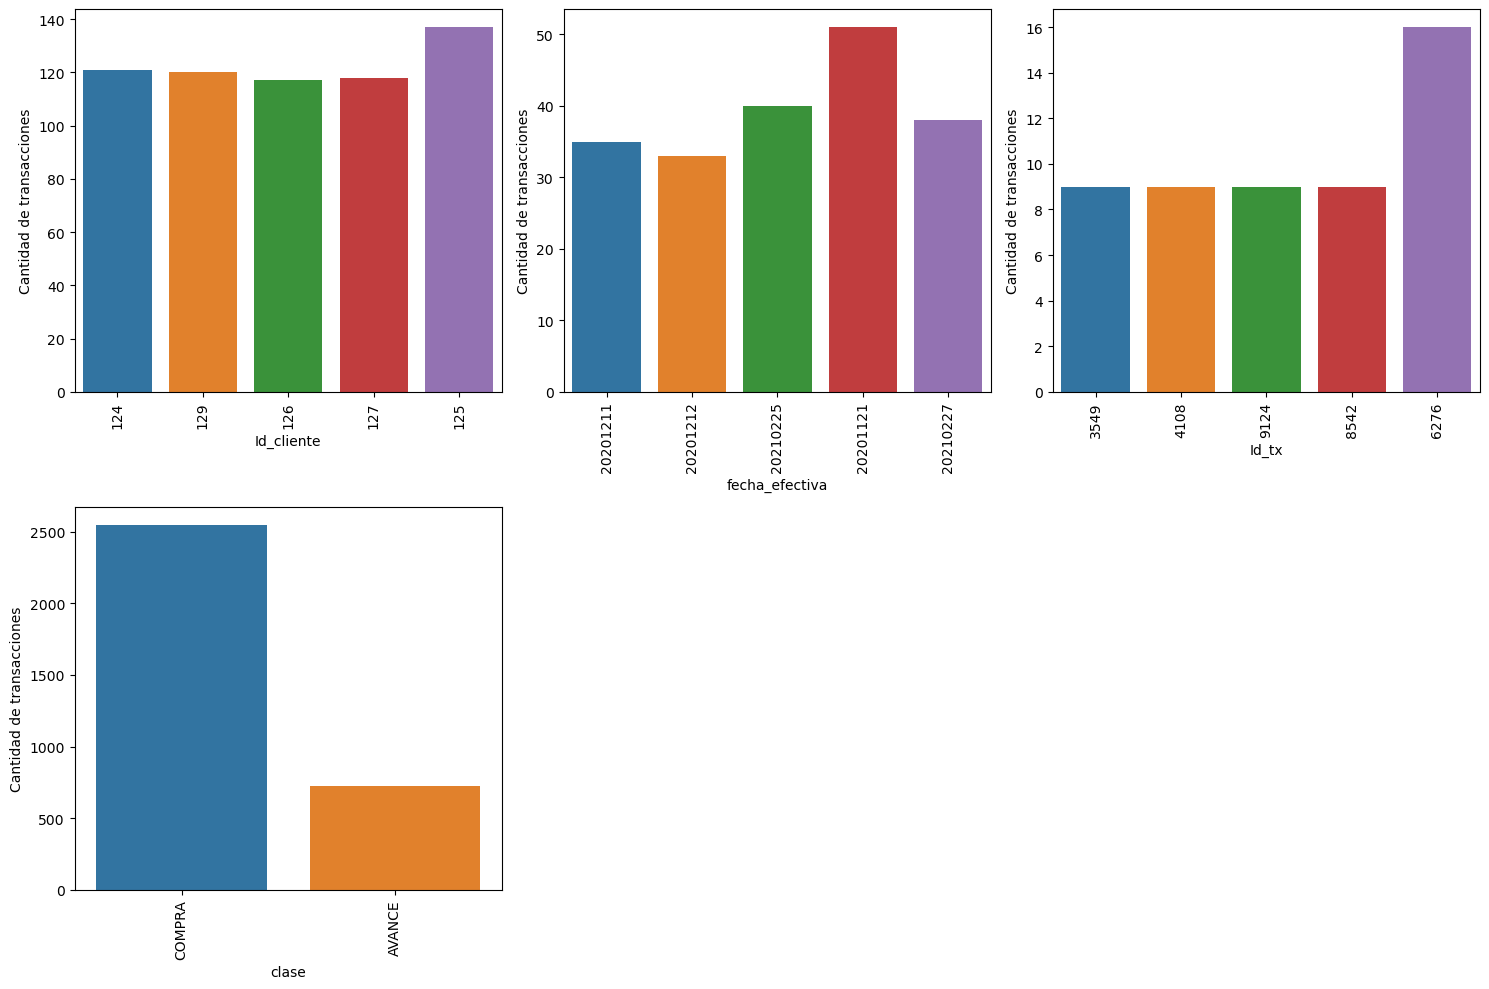

In [15]:
# obteniendo los nombres de las columnas object (columnas categoricas)
cat_vars = df.select_dtypes(include='object').columns.tolist()

# creando una figura con los subplots
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# creando grafico de barras para cada variable categorica
for i, var in enumerate(cat_vars):
    top_values = df[var].value_counts().nlargest(5).index
    filtered_df = df[df[var].isin(top_values)]
    ax = sns.countplot(x=var, data=filtered_df, ax=axs[i])
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].set_ylabel("Cantidad de transacciones")

# remueve los subplots que queden vacios
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# ajustando los espacios entre subplots
fig.tight_layout()

Acá podemos corroborar la información anterior a nivel visual, donde los casos puntuales se reflejan en el día 2020-11-21 y el código de transacción 6276.

### Manejo de valores atípicos

Debido a los valores atípico que encontramos en la columna valor, antes de realizar alguna gráfica de distribución debemos manejarlos ya que estos alterarán de gran manera la distribución de los datos. Para la correción de estos valores se usará el método de rango intercuartílico. Se mostrará una gráfica con outliers y luego sin ellos.

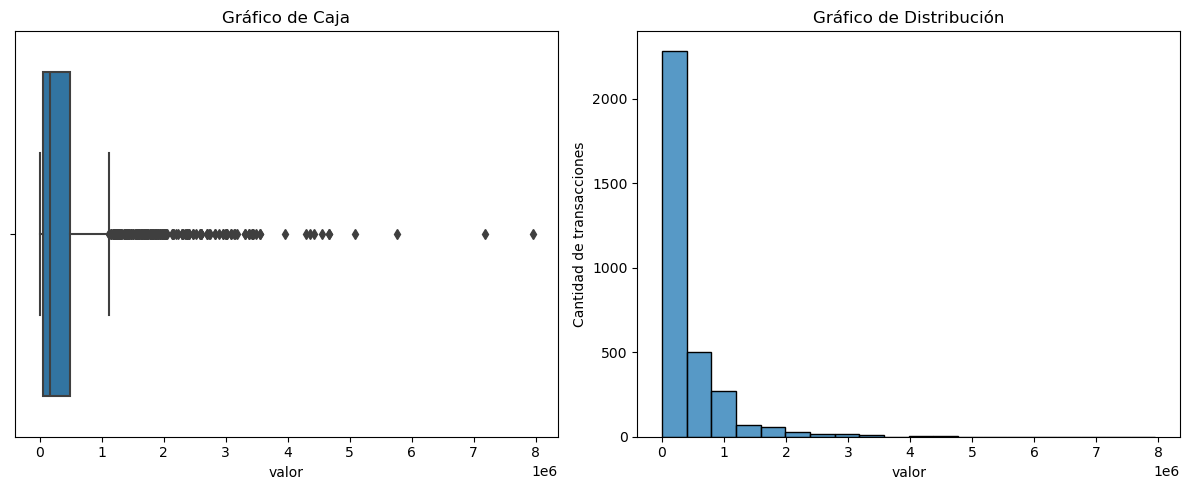

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # Creamos un lienzo de 1 fila y 2 columnas

sns.boxplot(x=df["valor"], ax=axes[0]) # Creamos el gráfico de caja
axes[0].set_title("Gráfico de Caja") # Título del gráfico

sns.histplot(df["valor"], bins=20, ax=axes[1]) # Creamos la distribución
axes[1].set_title("Gráfico de Distribución") # Título del gráfico
axes[1].set_ylabel("Cantidad de transacciones") # Título del eje y

plt.tight_layout() # Ajustando gráficos
plt.show() # Visualizando

A simple vista observamos los outliers con unos valores muy altos, estos outliers nos distorsionan la distribución. Procedemos a realizar el método de rango intercuartílico (IQR).

In [17]:
Q1 = df['valor'].quantile(0.25)
Q3 = df['valor'].quantile(0.75)

IQR = Q3 - Q1 # Calcular el rango intercuartílico (IQR)

lower_limit = Q1 - 1.5 * IQR # Definir límites para detectar outliers
upper_limit = Q3 + 1.5 * IQR

df = df[(df['valor'] >= lower_limit) & (df['valor'] <= upper_limit)] # Filtrar valores que están dentro del rango límite

### Distribución del valor de las transacciones

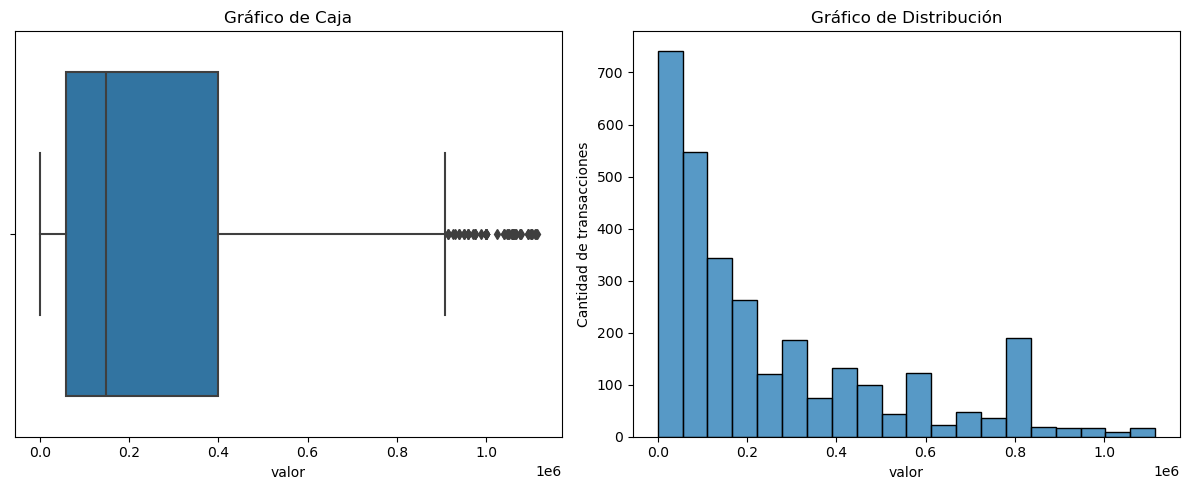

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # Creamos un lienzo de 1 fila y 2 columnas

sns.boxplot(x=df["valor"], ax=axes[0]) # Creamos el gráfico de caja
axes[0].set_title("Gráfico de Caja") # Título del gráfico

sns.histplot(df["valor"], bins=20, ax=axes[1]) # Creamos la distribución
axes[1].set_title("Gráfico de Distribución") # Título del gráfico
axes[1].set_ylabel("Cantidad de transacciones") # Título del eje y

plt.tight_layout() # Ajustando gráficos
plt.show() # Visualizando

Acá ya podemos observar una distribución más real, donde a pesar de existir algunos outliers, podemos decir que son tolerables. De acá podemos extraer el hecho que la distribución de la mayoría de las transacciones rondan entre los 50mil y 400mil y la mediana ronda los 150mil. Se puede decir que las transacciones más habituales son las menores de 100mil.

### Valor total por transacciones por fecha

Vamos a graficar la suma total de las transacciones por mes, semana y día. Esto con el fin de poder identificar patrones y tendencias. Primeramente cambiaremos el formato de nuestra columna de fecha y seguidamente procedemos a crear un dataframe donde su índice corresponderá a la columna fecha_efectiva y así poder graficar.

In [19]:
# Cambiando el formato de la columna fecha_efectiva a formato %Y%m%d
df['fecha_efectiva'] = pd.to_datetime(df['fecha_efectiva'], format='%Y%m%d')

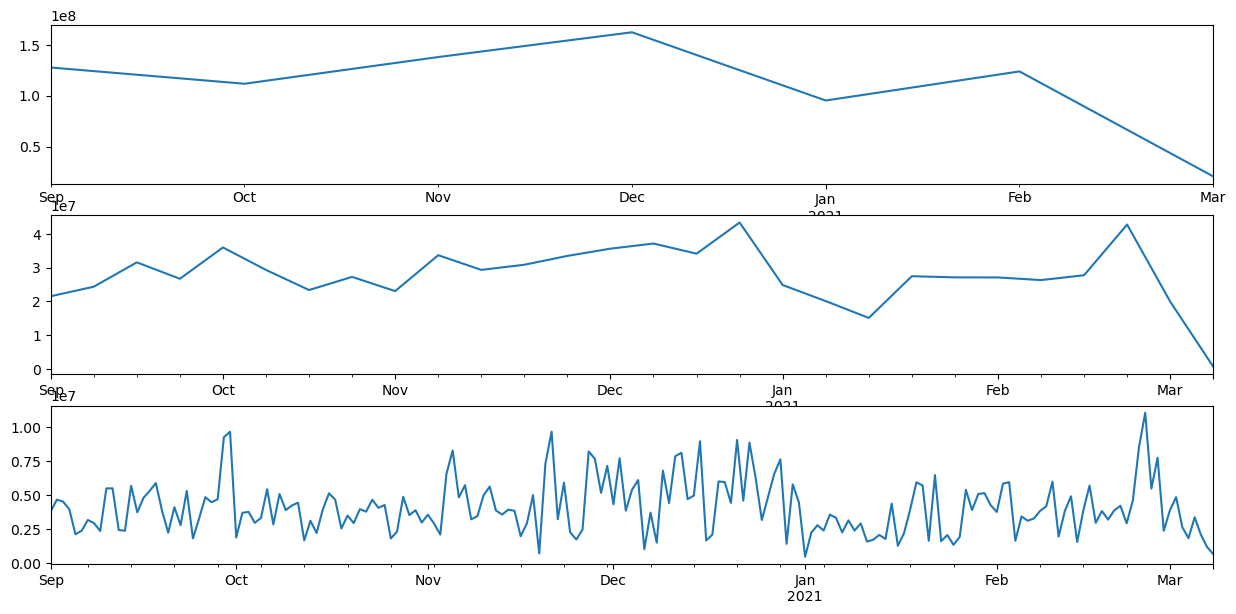

In [20]:
# Creando dataframe donde el indice corresponde a la fecha_efectiva
df_tendencia = df.set_index("fecha_efectiva")

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 7), sharex = False) # Creando el lienzo

# Agrupando los datos por mes
df_tendencia["valor"].resample("MS").sum().plot(ax = ax1)
ax1.set_xlabel("")

# Agrupando los datos por semanas
df_tendencia["valor"].resample("W").sum().plot(ax = ax2)
ax2.set_xlabel("")

# Agrupando los datos por dias
df_tendencia["valor"].resample("D").sum().plot(ax = ax3)
ax3.set_xlabel("")

plt.show() # Visualizando gráfico

A nivel mensual (Fig.1), visualizamos que desde Diciembre han venido disminuyendo lo generado por las transacciones, podemos deducir que después de Diciembre entramos en temporada baja y esto se traduzca en menos valor generado. A nivel semanal (Fig.2), desde Septiembre la tendencia se mantuvo estable pero en las primeras semanas de Enero se generó una abrupta caída, lo cual es normal para este tipo de negocios y hubo un repunte en las últimas semanas de Febrero. A nivel diario (Fig.3), se visualiza mucho ruido y el cual no permite ver una tendencia definida.

## Segmentación

Crearemos un dataframe que contenga solo los registros del mes de Febrero, haciendo la simulación de que esas transacciones fueran de Febrero de este año y los descuentos los aplicariamos a este mes actual de Marzo y así simular sus actividades del mes anterior y poder definir en que clientes enfocarnos y aplicar los descuentos correspondientes. El dataframe será la unión de la agrupación del valor total generado por clientes, total de transacciones por clientes, total de transacciones de compra por cliente y total de transacciones de compra por avance del mes de Febrero.

In [21]:
# Creando dataframe que contenga solo los datos de Febrero
febrero_df = df[df['fecha_efectiva'].dt.month == 2]

### Agrupación por valor generado

In [22]:
# Agrupando clientes por total de la suma del valor
clientes_valor = febrero_df.groupby('Id_cliente')['valor'].sum().sort_values(ascending=False).reset_index()
# Renombrando columna
clientes_valor.rename(columns={'valor': 'valor_total_generado'}, inplace=True)
clientes_valor.head() # Visualizando dataframe

,Id_cliente,valor_total_generado
0,123,7726231.00
1,129,6996311.63
2,122,6824276.05
3,118,6612805.00
4,131,4689364.00


### Agrupación por total de transacciones

In [23]:
# Agrupando clientes por total de las transacciones
clientes_tx = febrero_df.groupby('Id_cliente')['Id_tx'].count().sort_values(ascending=False).reset_index()
# Renombrando columna
clientes_tx.rename(columns={'Id_tx': 'total_transacciones'}, inplace=True)
clientes_tx.head() # Visualizando dataframe

,Id_cliente,total_transacciones
0,118,27
1,123,24
2,129,23
3,128,22
4,122,21


### Agrupación por total de transacciones compra

In [24]:
# Filtrando el dataframe para obtener solo las compra
clientes_compra = febrero_df[febrero_df['clase'] == 'COMPRA']
# Agrupando clientes por total de las transacciones
clientes_compra = clientes_compra.groupby('Id_cliente')['clase'].count().sort_values(ascending=False).reset_index()
# Renombrando columna
clientes_compra.rename(columns={'clase': 'total_transacciones_compra'}, inplace=True)
clientes_compra.head() # Visualizando dataframe

,Id_cliente,total_transacciones_compra
0,118,25
1,128,19
2,129,18
3,123,16
4,126,14


### Agrupación por total de transacciones avance

In [25]:
# Filtrando el dataframe para obtener solo las avance
clientes_avance = febrero_df[febrero_df['clase'] == 'AVANCE']
# Agrupando clientes por total de las transacciones
clientes_avance = clientes_avance.groupby('Id_cliente')['clase'].count().sort_values(ascending=False).reset_index()
# Renombrando columna
clientes_avance.rename(columns={'clase': 'total_transacciones_avance'}, inplace=True)
clientes_avance.head() # Visualizando dataframe

,Id_cliente,total_transacciones_avance
0,122,9
1,123,8
2,136,8
3,132,6
4,129,5


### Dataframe final

In [26]:
# Uniendo las 4 tablas de agrupaciones
df_final = pd.merge(clientes_valor, clientes_tx, left_on='Id_cliente', right_on='Id_cliente', how='left')
df_final = pd.merge(df_final, clientes_compra, left_on='Id_cliente', right_on='Id_cliente', how='left')
df_final = pd.merge(df_final, clientes_avance, left_on='Id_cliente', right_on='Id_cliente', how='left')

# Creando la columna %avances
df_final['%avances'] = round((df_final['total_transacciones_avance'] / df_final['total_transacciones']) * 100, 2)

df_final.to_csv('clientes.csv', index=False) # Guardando archivo con los clientes del mes de Febrero
df_final.head() # Visualizando dataframe

,Id_cliente,valor_total_generado,total_transacciones,total_transacciones_compra,total_transacciones_avance,%avances
0,123,7726231.00,24,16.0,8.0,33.33
1,129,6996311.63,23,18.0,5.0,21.74
2,122,6824276.05,21,12.0,9.0,42.86
3,118,6612805.00,27,25.0,2.0,7.41
4,131,4689364.00,11,8.0,3.0,27.27


Al tener nuestro dataframe definido para la segmentación de clientes, procedemos a definir los parámetros por los cuales se realizará la misma:

## Asignación de grupos

Luego de realizar un análisis al dataframe que contiene los datos consolidados del mes de febrero de los cliente, se llegó a la conclusión de crear tres formas de incentivos:

- ### Incentivo por ganancias generadas

Este incentivo se dividirá en tres grupos:
- VIP: Clientes que durante el mes hayan generado más de 5 millones, recibirán un 25% de descuento en su siguiente compra.
- Gold: Clientes que durante el mes hayan generado más de 4 millones, recibirán un 20% de descuento en su siguiente compra.
- Silver: Clientes que durante el mes hayan generado más de 2 millones, recibirán un 5% de descuento en su siguiente compra.

- ### Incentivo por cantidad de transacciones

Este incentivo se dividirá en tres grupos:
- VIP: Clientes que durante el mes hayan tenido más de 20 transacciones y por lo menos 15 de ellas fueron por compra, recibirán un 25% de descuento en su siguiente compra.
- Gold: Clientes que durante el mes hayan tenido más de 15 transacciones y por lo menos 11 de ellas fueron por compra, recibirán un 20% de descuento en su siguiente compra.
- Silver: Clientes que durante el mes hayan tenido más de 10 transacciones y por lo menos 7 de ellas fueron por compra, recibirán un 5% de descuento en su siguiente compra.

- ### Incentivo para promover compras y no avances

Este incentivo se aplicará a los clientes que no cumplan con las condiciones anteriores y que sus transacciones por avances sean mayores al 20% del total de sus transacciones, se les incentivará con un 20% de descuento en su próxima compra.

Los clientes que no cumplan con ninguno de los incentivos, no aplicaran a ningún incentivo.

## Justificación de la asignación de grupos

Estas medidas se tomaron pensando primeramente en los clientes que nos generan más ganancias y realizan más transacciones, ya que estos clientes representan un gran porcentaje del total de las ganancias. Dependiendo de los hábitos que tengan a con la compañía, se les premiará con alguno de los beneficios mencionados anteriormente. Además, se tomó en cuenta el tipo de transacción para incentivar las compras y no los avances.